In [1]:
# %reset
import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']=".97"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']="False"

# Change the current working directory to the desired path
os.chdir('/mnt/home/spandey/ceph/GODMAX/src/')
from jax.config import config
config.update("jax_enable_x64", True)
import numpy as np
import jax.numpy as jnp
import colossus 
from jax import vmap, grad
%matplotlib inline
import matplotlib.pyplot as pl
pl.rc('text', usetex=True)
# Palatino
pl.rc('font', family='DejaVu Sans')
#import pyccl as ccl
import pickle as pk
import scipy.interpolate as interp

%load_ext autoreload
%autoreload 2

import warnings

# Suppress RuntimeWarnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)



/tmp/ipykernel_465404/1829470593.py:9: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [2]:
cosmo_params_dict = {'flat': True, 'H0': 70.0, 'Om0': 0.2793, 'Ob0': 0.0463, 'sigma8': 0.821, 'ns': 0.972, 'w0':-1.0}
sim_params_dict = {}
sim_params_dict['nfw_trunc'] = True
sim_params_dict['gamma_rhogas'] = 5.0
sim_params_dict['delta_rhogas'] = 9.0
# sim_params_dict['theta_co'] = 0.01
# sim_params_dict['theta_ej'] = 1.0

sim_params_dict['theta_co_0'] = 0.01
sim_params_dict['log10_Mstar0_theta_co'] = 15.0
sim_params_dict['nu_theta_co_M'] = 0.0
sim_params_dict['nu_theta_co_z'] = 0.0

sim_params_dict['theta_ej_0'] = 4.0
sim_params_dict['log10_Mstar0_theta_ej'] = 15.0
sim_params_dict['nu_theta_ej_M'] = 0.0
sim_params_dict['nu_theta_ej_z'] = 0.5

sim_params_dict['log10_Mc0'] = 15.1
sim_params_dict['log10_Mstar0'] = 14.0
sim_params_dict['mu_beta'] = 0.21
sim_params_dict['nu_z'] = -5.0
sim_params_dict['nu_M'] = 0.0

sim_params_dict['eta_star'] = 0.3
sim_params_dict['eta_cga'] = 0.6


sim_params_dict['neg_bhse_plus_1'] = 0.833
sim_params_dict['A_starcga'] = 0.09
sim_params_dict['log10_M1_starcga'] = 11.4
sim_params_dict['epsilon_rt'] = 4.0


sim_params_dict['a_zeta'] = 0.3
sim_params_dict['n_zeta'] = 2
sim_params_dict['alpha_nt'] = 0.18
sim_params_dict['beta_nt'] = 0.5
sim_params_dict['n_nt'] = 0.3
sim_params_dict['cosmo'] = cosmo_params_dict


halo_params_dict = {}
halo_params_dict['rmin'], halo_params_dict['rmax'], halo_params_dict['nr'] = 1e-3, 18, 128
# halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.001, 0.002, 2
# halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.001, 1.0, 10
halo_params_dict['z_array'] = np.array([1e-3, 0.5, 1.0])
# halo_params_dict['z_array'] = np.array([1e-3])
# halo_params_dict['z_array'] = np.array([0.5])
# halo_params_dict['z_array'] = np.array([1.0])
halo_params_dict['nz'] = len(halo_params_dict['z_array'])
halo_params_dict['lg10_Mmin'], halo_params_dict['lg10_Mmax'], halo_params_dict['nM'] = 13.0, 14.5, 48
halo_params_dict['cmin'], halo_params_dict['cmax'], halo_params_dict['nc'] = 3, 7, 24
halo_params_dict['ellmin'], halo_params_dict['ellmax'], halo_params_dict['nell'] = 8, 2**15, 64
# try:
halo_params_dict['sig_logc_z_array'] = np.ones(halo_params_dict['nz']) * 0.01
halo_params_dict['mdef'] = '200c'
halo_params_dict['hmf_model'] = 'T10'
halo_params_dict['conc_model'] = 'Diemer15'
halo_params_dict['do_corr_2h_mm'] = True

# halo_params_dict['do_corr_2h_mm'] = False

from astropy.io import fits
df = fits.open('/mnt/home/spandey/ceph/GODMAX/data/sim_3x2pt_simulated_DV_PKproject_values_bestfit_maglim_3x2LCDM_final.fits') 
z_array = df['nz_source'].data['Z_MID']
nz_info_dict = {}
nz_info_dict['z_array'] = z_array
nz_info_dict['nbins'] = 4
nz_info_dict['nz0'] = np.maximum(df['nz_source'].data['BIN1'], 1e-4)
nz_info_dict['nz1'] = np.maximum(df['nz_source'].data['BIN2'], 1e-4)
nz_info_dict['nz2'] = np.maximum(df['nz_source'].data['BIN3'], 1e-4)
nz_info_dict['nz3'] = np.maximum(df['nz_source'].data['BIN4'], 1e-4)
analysis_dict = {}
analysis_dict['nz_info_dict'] = nz_info_dict
analysis_dict['do_sheary'] = True
analysis_dict['do_shear2pt'] = True
analysis_dict['do_yy'] = False

df_data = fits.open('/mnt/home/spandey/ceph/GODMAX/data/DES_ACT_full_data_theorycov_2.5.fits')
theta_data = df_data['compton_shear'].data['ANG'][0:20]

analysis_dict['ellmin_transf'], analysis_dict['ellmax_transf'], analysis_dict['nell_transf'] = 8, 2**15, 16384
analysis_dict['angles_data_array'] = jnp.array(theta_data)
analysis_dict['beam_fwhm_arcmin'] = 1.6
analysis_dict['want_like_diff'] = False
analysis_dict['calc_nfw_only'] = True





In [3]:
z_array_fit = np.array([0.001, 0.5, 1.0])
snap_num_fit = np.array([32, 28, 26])
lgM_bin_min = jnp.array([13.0, 13.5, 14.0])
lgM_bin_max = jnp.array([13.5, 14.0, 14.5])
lgM_bin_mean = 0.5*(lgM_bin_min + lgM_bin_max)

# df_all_data = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/ANTILES/profiles_all_sims_all_snaps_lite.pkl', 'rb'))
df_all_data = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/ANTILES/profiles_all_sims_all_snaps.pkl', 'rb'))








In [4]:
all_sims_names = list(df_all_data.keys())
print(len(all_sims_names))




200


In [5]:
# saved_plot_data_all = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/ANTILES/fitting_results_all_sims_wparams.pkl','rb'))
saved_plot_data_all = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/ANTILES/fitting_results_all_sims_wparams_FINALSET.pkl','rb'))
mean_err_all = []
mean_err_sigma_all = []
keys_all = []
params_all = np.zeros((len(saved_plot_data_all.keys()), len(saved_plot_data_all[all_sims_names[0]]['params_bestfit'])))
for jsim in range(len(all_sims_names)):
    try:
        mean_err = saved_plot_data_all[all_sims_names[jsim]]['mean_err']
        mean_err_sigma = saved_plot_data_all[all_sims_names[jsim]]['mean_err_sigma']
        keys_all.append(all_sims_names[jsim])
        mean_err_all.append(mean_err)
        mean_err_sigma_all.append(mean_err_sigma)
        params_all[jsim,:] = saved_plot_data_all[all_sims_names[jsim]]['params_bestfit']
    except:
        pass

all_sims_names = keys_all


In [6]:
from colossus.cosmology import cosmology
from colossus.halo import concentration
from colossus.lss import mass_function
import scipy.interpolate as interpolate

cosmo = cosmology.setCosmology('myCosmo', **cosmo_params_dict)

# from get_corr_func_jit import get_corrfunc_BCMP
from get_BCMP_profile_jit import BCM_18_wP
import numpyro
import copy
# from jax_cosmo.scipy.interpolate import interp
import scipy.interpolate as interp
from jax import grad
from jax import vmap
from jax import value_and_grad

from jaxopt import ScipyBoundedMinimize
from jaxopt import LBFGSB

# params_vary_names = ['n_nt', 'alpha_nt', 'theta_ej_0', 'log10_Mstar0_theta_ej', 'nu_theta_ej_M', 'theta_co_0', 'nu_theta_co_M', 'nu_theta_ej_z', 'nu_z', 'log10_Mc0', 'gamma_rhogas', 'delta_rhogas', 'mu_beta', 'eta_star', 'eta_cga']
# lower_bounds = jnp.array([0.0001, -3.0, 0.00001, -8.0, -8.0, -8.0, 10.0, 0.01, 0.01, -1.0, 0.05, 0.3])
# upper_bounds = jnp.array([8.0, 3.0, 0.8, 3.0, 3.0, 3.0, 17.0, 8.0, 15.0, 0.8, 8.0, 5.0])
lower_bounds_dict = {'n_nt':0.0001, 'alpha_nt':0.01 , 'log10_Mstar0_theta_ej':11.0, 'theta_ej_0': 0.5, 'nu_theta_ej_M': -5.0, 'theta_co_0': 1e-12, 'nu_theta_co_M': -8.0, 'nu_theta_ej_z': -8.0, 'nu_z': -8.0, 'log10_Mc0': 10.0, 'gamma_rhogas': 0.2, 'delta_rhogas': 0.01, 'mu_beta': 0.0, 'eta_star': 0.001, 'eta_cga': 0.01}
upper_bounds_dict = {'n_nt':0.7,'alpha_nt':0.5 , 'log10_Mstar0_theta_ej':15.0,'theta_ej_0': 8.0, 'nu_theta_ej_M': 0.0, 'theta_co_0': 0.8, 'nu_theta_co_M': 3.0, 'nu_theta_ej_z': 5.0, 'nu_z': 8.0, 'log10_Mc0': 16.5, 'gamma_rhogas': 6.0, 'delta_rhogas': 15.0, 'mu_beta': 5.0, 'eta_star': 0.6, 'eta_cga': 1.0}


# params_vary_names = ['n_nt', 'theta_ej_0', 'nu_theta_ej_M', 'nu_theta_co_M', 'nu_theta_ej_z', 'nu_z', 'theta_co_0', 'gamma_rhogas']
# params_vary_names = ['eta_star','alpha_nt', 'theta_ej_0', 'theta_co_0', 'nu_theta_ej_M', 'nu_theta_ej_z', 'nu_z', 'log10_Mc0', 'mu_beta', 'delta_rhogas', 'gamma_rhogas']

# params_vary_names = ['theta_ej_0', 'theta_co_0', 'gamma_rhogas','mu_beta','eta_star','alpha_nt', 'log10_Mc0','nu_theta_ej_M']
params_vary_names = ['theta_ej_0', 'theta_co_0','nu_z', 'nu_theta_ej_z', 'gamma_rhogas','mu_beta', 'log10_Mc0','eta_star','alpha_nt', 'nu_theta_ej_M']
# params_vary_names = ['theta_ej_0', 'theta_co_0','nu_z', 'gamma_rhogas','mu_beta', 'log10_Mc0','eta_star','alpha_nt']

fid_parm_val = []
for pname in params_vary_names:
    fid_parm_val.append(sim_params_dict[pname])


/mnt/home/spandey/venv_gm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
jsim = 149



In [8]:
df_at = df_all_data[all_sims_names[jsim]][snap_num_fit[0]]

# dg_val = 3
# x_array_data_all = df_at['r_r200c'][::dg_val]

# xmin, xmax = 0.05, 1.0
# indselx = np.where((x_array_data_all > xmin) & (x_array_data_all < xmax))[0]
# x_array_data = x_array_data_all[indselx]

# # lgmass_all = df_at['lgmass_all']
# rho_dmb_dv = np.zeros((len(z_array_fit), len(lgM_bin_min), len(x_array_data)))
# ne_dv = np.zeros((len(z_array_fit), len(lgM_bin_min), len(x_array_data)))
# Pe_dv = np.zeros((len(z_array_fit), len(lgM_bin_min), len(x_array_data)))

# sig_rho_dmb_dv = np.zeros((len(z_array_fit), len(lgM_bin_min), len(x_array_data)))
# sig_ne_dv = np.zeros((len(z_array_fit), len(lgM_bin_min), len(x_array_data)))
# sig_Pe_gas_dv = np.zeros((len(z_array_fit), len(lgM_bin_min), len(x_array_data)))

# for jz in range(len(z_array_fit)):
#     snap_num_jz = snap_num_fit[jz]
#     # print('snap_num_jz = ' + str(snap_num_jz))
#     # df_at = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/ANTILES/profiles_all_lowTAGN_zs_' + str(snap_num_jz) + '.pkl','rb'))
#     # df_at = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/ANTILES/profiles_all_highTAGN_zs_' + str(snap_num_jz) + '.pkl','rb'))    
#     df_at = df_all_data[all_sims_names[jsim]][snap_num_jz]
#     M_dmo_all = df_at['M_dmo']
#     rho_dmb_all = df_at['rho_dmb_all']
#     # rho_gas_all = df_at['rho_gas_all']
#     ne_all = df_at['ne_all']    
#     Pe_all = df_at['P_all']
#     lgM_dmo_all = np.log10(M_dmo_all)
#     for jM in range(len(lgM_bin_min)):
#         indselM = np.where((lgM_dmo_all > lgM_bin_min[jM]) & (lgM_dmo_all < lgM_bin_max[jM]))[0]
#         # print(indselM.shape)

#         rho_dmb_dv_all_jM = np.zeros((len(indselM), len(x_array_data)))
#         ne_dv_all_jM = np.zeros((len(indselM), len(x_array_data)))
#         Pe_dv_all_jM = np.zeros((len(indselM), len(x_array_data)))
#         for jbM in range(len(indselM)):
#             rho_dmb_interp = interp.interp1d(np.log(df_at['r_r200c']), np.log(rho_dmb_all[indselM[jbM],:]))
#             rho_dmb_dv_all_jM[jbM, :] = np.exp(rho_dmb_interp(np.log(x_array_data)))

#             ne_interp = interp.interp1d(np.log(df_at['r_r200c']), np.log(ne_all[indselM[jbM],:]))
#             ne_dv_all_jM[jbM, :] = np.exp(ne_interp(np.log(x_array_data)))

#             Pe_interp = interp.interp1d(np.log(df_at['r_r200c']), np.log(Pe_all[indselM[jbM],:]))
#             Pe_dv_all_jM[jbM, :] = np.exp(Pe_interp(np.log(x_array_data)))
        


#         rho_dmb_dv[jz, jM, :] = np.mean(rho_dmb_dv_all_jM, axis=0)
#         ne_dv[jz, jM, :] = np.mean(ne_dv_all_jM, axis=0)
#         Pe_dv[jz, jM, :] = np.mean(Pe_dv_all_jM, axis=0)

#         sig_rho_dmb_dv[jz, jM, :] = np.std(rho_dmb_dv_all_jM, axis=0)
#         sig_ne_dv[jz, jM, :] = np.std(ne_dv_all_jM, axis=0)
#         sig_Pe_gas_dv[jz, jM, :] = np.std(Pe_dv_all_jM, axis=0)


# dmb_dv_flatten_sims = rho_dmb_dv.flatten()
# gas_dv_flatten_sims = ne_dv.flatten()
# Pgas_dv_flatten_sims = Pe_dv.flatten()
# sig_dmb_dv_flatten_sims = sig_rho_dmb_dv.flatten()
# sig_gas_dv_flatten_sims = sig_ne_dv.flatten()
# sig_Pgas_dv_flatten_sims = sig_Pe_gas_dv.flatten()

# dv_combined = jnp.concatenate((dmb_dv_flatten_sims, gas_dv_flatten_sims, Pgas_dv_flatten_sims))
# ind_finite = jnp.where(jnp.isfinite(dv_combined))[0]
# dv_combined = dv_combined[ind_finite]
# # sigma_value_combined = 0.05*dv_combined
# sigma_value_combined = jnp.concatenate((sig_dmb_dv_flatten_sims, sig_gas_dv_flatten_sims, sig_Pgas_dv_flatten_sims))
# sigma_value_combined = sigma_value_combined[ind_finite]
# # sigma_value_combined = 0.05*dv_combined
# cov_combined = jnp.diag(sigma_value_combined**2)
# # precision_combined = jnp.linalg.inv(cov_combined)
# precision_combined = jnp.diag(1./sigma_value_combined**2)

# # from get_BCMP_profile_jit import BCM_18_wP
BCMP_test = BCM_18_wP(sim_params_dict, halo_params_dict)
# rho_dmb = BCMP_test.rho_dmb_mat_physical
# # # rho_gas = BCMP_test.rho_gas_mat_physical
# ne_gas = BCMP_test.ne_mat_physical
# Pe_gas = BCMP_test.Pe_mat_physical

x_array_data = np.logspace(-2.5, 0.7, 32)
masks_all = np.zeros(( len(z_array_fit), len(lgM_bin_min),len(x_array_data), halo_params_dict['nc'], halo_params_dict['nz'], halo_params_dict['nM']))
dndlnM_jb_repeat_all = np.zeros((len(z_array_fit), len(lgM_bin_min),len(x_array_data), halo_params_dict['nc'], halo_params_dict['nz'], halo_params_dict['nM']))
norm_value_all = np.zeros((len(z_array_fit),len(lgM_bin_min)))


for jz in range(len(z_array_fit)):
    zmean = z_array_fit[jz]

    cmean_array = concentration.concentration(10**lgM_bin_mean, '200c', zmean, model = 'diemer19')
    cmean_array = jnp.array(cmean_array)

    lg10_Mmin, lg10_Mmax, nM = halo_params_dict['lg10_Mmin'], halo_params_dict['lg10_Mmax'], halo_params_dict['nM']
    M200c_array = jnp.logspace(lg10_Mmin, lg10_Mmax, nM)
    # dndlnM_th = mass_function.massFunction(M200c_array, zmean, mdef = '200c', model = 'tinker08', q_out='dndlnM')
    # dndlnM_th = jnp.array(dndlnM_th)
    snap_num_jz = snap_num_fit[jz]    
    # df_at = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/ANTILES/profiles_all_highTAGN_zs_' + str(snap_num_jz) + '.pkl','rb'))    
    df_at = df_all_data[all_sims_names[jsim]][snap_num_jz]
    M_dmo_all = df_at['M_dmo']
    zmean = z_array_fit[0]
    # len(M_dmo_all)
    # vol = 100**3
    lg10_Mmin, lg10_Mmax, nM = halo_params_dict['lg10_Mmin'], halo_params_dict['lg10_Mmax'], halo_params_dict['nM']
    M200c_array = jnp.logspace(lg10_Mmin, lg10_Mmax, nM)

    lg10Mbins_all = np.linspace(12.8, 15.0, 18)
    # lg10Mbins_all = np.array([13.0, 13.5, 14.0, 14.5 ])
    lg10Mbins_cent = 0.5*(lg10Mbins_all[1:] + lg10Mbins_all[:-1])

    hist_dmo = np.histogram(np.log10(M_dmo_all), bins=lg10Mbins_all)
    # get dn/dlnM from this histogram:
    vol = 100**3
    n_hist = hist_dmo[0]/vol
    n_hist = n_hist/np.diff(lg10Mbins_all)
    n_hist = n_hist/np.log(10)

    f_nhist = interpolate.interp1d(np.log(10**lg10Mbins_cent), np.log(n_hist + 1e-20), kind='cubic')

    dndlnM_th = jnp.exp(jnp.array(f_nhist(np.log(M200c_array))))

    # dndlnM_jb_repeat_all = {}
    for jb in range(len(lgM_bin_min)):
        lgM_min_jb = lgM_bin_min[jb]
        lgM_max_jb = lgM_bin_max[jb]
        cmean_jb = cmean_array[jb]
        c_array_th = jnp.exp(jnp.linspace(jnp.log(halo_params_dict['cmin']), jnp.log(halo_params_dict['cmax']), halo_params_dict['nc']))
        indc = jnp.argmin(jnp.abs(c_array_th - cmean_jb))
        # print(indc, cmean_jb)
        # lgM_array_th = jnp.log10(jnp.logspace(halo_params_dict['lg10_Mmin'], halo_params_dict['lg10_Mmax'], halo_params_dict['nM']))
        M_array_th = BCMP_test.M_array
        # M_array_th = np.logspace(halo_params_dict['lg10_Mmin'], halo_params_dict['lg10_Mmax'], halo_params_dict['nM'])
        # M_array_th = BCMP_test.Mdmb_r200_mat[indc, 0, :]
        lgM_array_th = jnp.log10(M_array_th)
        indM_min = jnp.argmin(jnp.abs(lgM_array_th - lgM_min_jb))
        indM_max = jnp.argmin(jnp.abs(lgM_array_th - lgM_max_jb))
        # mask = jnp.zeros((halo_params_dict['nr'], halo_params_dict['nc'], halo_params_dict['nz'], halo_params_dict['nM']))
        # mask = jax.ops.index_update(mask, jax.ops.index[:, indc, 0, indM_min:indM_max+1], 1)
        # mask = mask.at[:, indc, 0, indM_min:indM_max+1].set(1)
        masks_all[jz, jb,:, indc, jz, indM_min:indM_max+1] = 1
        # print(jz, jb, indc, jz, indM_min,indM_max+1)
        dndlnM_jb_repeat = jnp.tile(dndlnM_th.reshape(1,1,1,masks_all.shape[-1]), (masks_all.shape[-4],masks_all.shape[-3],masks_all.shape[-2], 1))
        # dndlnM_jb_repeat *= mask
        # dndlnM_jb_repeat_all[jb] = dndlnM_jb_repeat
        norm_value = jnp.trapz(dndlnM_th[indM_min:indM_max+1], jnp.log(M_array_th)[indM_min:indM_max+1])
        norm_value_all[jz,jb] = norm_value
        # print(norm_value)
        dndlnM_jb_repeat_all[jz,jb,...] = dndlnM_jb_repeat * masks_all[jz,jb,...]

masks_all = jnp.array(masks_all.astype(int))
dndlnM_jb_repeat_all = jnp.array(dndlnM_jb_repeat_all)
norm_value_all = jnp.array(norm_value_all)




In [24]:

def get_model(x):

    sim_params_dict_vary = copy.deepcopy(sim_params_dict)
    
    for jp in range(len(params_vary_names)):
        sim_params_dict_vary[params_vary_names[jp]] = x[jp]

    
    # Now that params are defined, here is the forward model
    # get_corrfunc_BCMP_obj = get_corrfunc_BCMP(sim_params_dict_vary, halo_params_dict, analysis_dict,num_points_trapz_int=32)
    BCMP_test_vary = BCM_18_wP(sim_params_dict_vary, halo_params_dict)
    # theory = BCMP_test_vary.rho_dmb_mat

    rho_dmb = BCMP_test_vary.rho_dmb_mat
    rho_clm = BCMP_test_vary.rho_clm_mat
    rho_cga = BCMP_test_vary.rho_cga_mat
    rho_gas = BCMP_test_vary.rho_gas_mat
    rho_nfw = BCMP_test_vary.rho_nfw_mat
    # rho_gas = BCMP_test_vary.rho_gas_mat_physical
    # ne_gas = BCMP_test_vary.ne_mat_physical    
    Ptot_mat = BCMP_test_vary.Ptot_mat
    Pth_mat = BCMP_test_vary.Pth_mat
    Pnt_mat = BCMP_test_vary.Pnt_mat
    
    def interp_rho_dmb(jc, jz, jM):
        rho_dmb_here = rho_dmb[:,jc, jz, jM]
        r_theory = BCMP_test_vary.r_array
        r200_here = BCMP_test_vary.r200c_mat[jM, jz]
        val_out = jnp.exp(jnp.interp(jnp.log(x_array_data), jnp.log(r_theory/r200_here), jnp.log(rho_dmb_here)))
        return val_out

    def interp_rho_clm(jc, jz, jM):
        rho_dmb_here = rho_clm[:,jc, jz, jM]
        r_theory = BCMP_test_vary.r_array
        r200_here = BCMP_test_vary.r200c_mat[jM, jz]
        val_out = jnp.exp(jnp.interp(jnp.log(x_array_data), jnp.log(r_theory/r200_here), jnp.log(rho_dmb_here)))
        return val_out    

    def interp_rho_cga(jc, jz, jM):
        rho_dmb_here = rho_cga[:,jc, jz, jM]
        r_theory = BCMP_test_vary.r_array
        r200_here = BCMP_test_vary.r200c_mat[jM, jz]
        val_out = jnp.exp(jnp.interp(jnp.log(x_array_data), jnp.log(r_theory/r200_here), jnp.log(rho_dmb_here)))
        return val_out    

    def interp_rho_gas(jc, jz, jM):
        rho_dmb_here = rho_gas[:,jc, jz, jM]
        r_theory = BCMP_test_vary.r_array
        r200_here = BCMP_test_vary.r200c_mat[jM, jz]
        val_out = jnp.exp(jnp.interp(jnp.log(x_array_data), jnp.log(r_theory/r200_here), jnp.log(rho_dmb_here)))
        return val_out

    def interp_rho_nfw(jc, jz, jM):
        rho_dmb_here = rho_nfw[:,jc, jz, jM]
        r_theory = BCMP_test_vary.r_array
        r200_here = BCMP_test_vary.r200c_mat[jM, jz]
        val_out = jnp.exp(jnp.interp(jnp.log(x_array_data), jnp.log(r_theory/r200_here), jnp.log(rho_dmb_here)))
        return val_out

    def interp_Ptot_gas(jc, jz, jM):
        rho_dmb_here = Ptot_mat[:,jc, jz, jM]
        r_theory = BCMP_test_vary.r_array
        r200_here = BCMP_test_vary.r200c_mat[jM, jz]
        val_out = jnp.exp(jnp.interp(jnp.log(x_array_data), jnp.log(r_theory/r200_here), jnp.log(rho_dmb_here)))
        return val_out

    def interp_Pth_gas(jc, jz, jM):
        rho_dmb_here = Pth_mat[:,jc, jz, jM]
        r_theory = BCMP_test_vary.r_array
        r200_here = BCMP_test_vary.r200c_mat[jM, jz]
        val_out = jnp.exp(jnp.interp(jnp.log(x_array_data), jnp.log(r_theory/r200_here), jnp.log(rho_dmb_here)))
        return val_out

    def interp_Pnt_gas(jc, jz, jM):
        rho_dmb_here = Pnt_mat[:,jc, jz, jM]
        r_theory = BCMP_test_vary.r_array
        r200_here = BCMP_test_vary.r200c_mat[jM, jz]
        val_out = jnp.exp(jnp.interp(jnp.log(x_array_data), jnp.log(r_theory/r200_here), jnp.log(rho_dmb_here)))
        return val_out

    vmap_func1 = vmap(interp_rho_dmb, (0, None, None))
    vmap_func2 = vmap(vmap_func1, (None, 0, None))
    vmap_func3 = vmap(vmap_func2, (None, None, 0))
    rhodmb_xbins_interp = vmap_func3(jnp.arange(halo_params_dict['nc']), jnp.arange(halo_params_dict['nz']), jnp.arange(halo_params_dict['nM'])).T

    vmap_func1 = vmap(interp_rho_clm, (0, None, None))
    vmap_func2 = vmap(vmap_func1, (None, 0, None))
    vmap_func3 = vmap(vmap_func2, (None, None, 0))
    rhoclm_xbins_interp = vmap_func3(jnp.arange(halo_params_dict['nc']), jnp.arange(halo_params_dict['nz']), jnp.arange(halo_params_dict['nM'])).T

    vmap_func1 = vmap(interp_rho_cga, (0, None, None))
    vmap_func2 = vmap(vmap_func1, (None, 0, None))
    vmap_func3 = vmap(vmap_func2, (None, None, 0))
    rhocga_xbins_interp = vmap_func3(jnp.arange(halo_params_dict['nc']), jnp.arange(halo_params_dict['nz']), jnp.arange(halo_params_dict['nM'])).T

    vmap_func1 = vmap(interp_rho_gas, (0, None, None))
    vmap_func2 = vmap(vmap_func1, (None, 0, None))
    vmap_func3 = vmap(vmap_func2, (None, None, 0))
    rhogas_xbins_interp = vmap_func3(jnp.arange(halo_params_dict['nc']), jnp.arange(halo_params_dict['nz']), jnp.arange(halo_params_dict['nM'])).T

    vmap_func1 = vmap(interp_rho_nfw, (0, None, None))
    vmap_func2 = vmap(vmap_func1, (None, 0, None))
    vmap_func3 = vmap(vmap_func2, (None, None, 0))
    rhonfw_xbins_interp = vmap_func3(jnp.arange(halo_params_dict['nc']), jnp.arange(halo_params_dict['nz']), jnp.arange(halo_params_dict['nM'])).T

    vmap_func1 = vmap(interp_Ptot_gas, (0, None, None))
    vmap_func2 = vmap(vmap_func1, (None, 0, None))
    vmap_func3 = vmap(vmap_func2, (None, None, 0))
    Ptot_xbins_interp = vmap_func3(jnp.arange(halo_params_dict['nc']), jnp.arange(halo_params_dict['nz']), jnp.arange(halo_params_dict['nM'])).T

    vmap_func1 = vmap(interp_Pth_gas, (0, None, None))
    vmap_func2 = vmap(vmap_func1, (None, 0, None))
    vmap_func3 = vmap(vmap_func2, (None, None, 0))
    Pth_xbins_interp = vmap_func3(jnp.arange(halo_params_dict['nc']), jnp.arange(halo_params_dict['nz']), jnp.arange(halo_params_dict['nM'])).T

    vmap_func1 = vmap(interp_Pnt_gas, (0, None, None))
    vmap_func2 = vmap(vmap_func1, (None, 0, None))
    vmap_func3 = vmap(vmap_func2, (None, None, 0))
    Pnt_xbins_interp = vmap_func3(jnp.arange(halo_params_dict['nc']), jnp.arange(halo_params_dict['nz']), jnp.arange(halo_params_dict['nM'])).T

    def get_mean_rhodmb(jbz,jbM):
        lgM_array_th = jnp.log10(BCMP_test_vary.M_array)
        M_array_th = 10**lgM_array_th
        mask = masks_all[jbz, jbM]
        # apply mask:
        rho_rM = rhodmb_xbins_interp * mask
        dndlnM_jb_repeat = dndlnM_jb_repeat_all[jbz, jbM]
        rho_mean = jnp.trapz(rho_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
        rho_mean = jnp.sum(rho_mean, axis=-1)
        rho_mean = jnp.sum(rho_mean, axis=-1)
        return rho_mean

    def get_mean_rhoclm(jbz,jbM):
        lgM_array_th = jnp.log10(BCMP_test_vary.M_array)
        M_array_th = 10**lgM_array_th
        mask = masks_all[jbz, jbM]
        # apply mask:
        rho_rM = rhoclm_xbins_interp * mask
        dndlnM_jb_repeat = dndlnM_jb_repeat_all[jbz, jbM]
        rho_mean = jnp.trapz(rho_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
        rho_mean = jnp.sum(rho_mean, axis=-1)
        rho_mean = jnp.sum(rho_mean, axis=-1)
        return rho_mean       

    def get_mean_rhocga(jbz,jbM):
        lgM_array_th = jnp.log10(BCMP_test_vary.M_array)
        M_array_th = 10**lgM_array_th
        mask = masks_all[jbz, jbM]
        # apply mask:
        rho_rM = rhocga_xbins_interp * mask
        dndlnM_jb_repeat = dndlnM_jb_repeat_all[jbz, jbM]
        rho_mean = jnp.trapz(rho_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
        rho_mean = jnp.sum(rho_mean, axis=-1)
        rho_mean = jnp.sum(rho_mean, axis=-1)
        return rho_mean   

    def get_mean_rhogas(jbz,jbM):
        lgM_array_th = jnp.log10(BCMP_test_vary.M_array)
        M_array_th = 10**lgM_array_th
        mask = masks_all[jbz, jbM]
        # apply mask:
        rho_rM = rhogas_xbins_interp * mask
        dndlnM_jb_repeat = dndlnM_jb_repeat_all[jbz, jbM]
        rho_mean = jnp.trapz(rho_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
        rho_mean = jnp.sum(rho_mean, axis=-1)
        rho_mean = jnp.sum(rho_mean, axis=-1)
        return rho_mean  

    def get_mean_rhonfw(jbz,jbM):
        lgM_array_th = jnp.log10(BCMP_test_vary.M_array)
        M_array_th = 10**lgM_array_th
        mask = masks_all[jbz, jbM]
        # apply mask:
        rho_rM = rhonfw_xbins_interp * mask
        dndlnM_jb_repeat = dndlnM_jb_repeat_all[jbz, jbM]
        rho_mean = jnp.trapz(rho_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
        rho_mean = jnp.sum(rho_mean, axis=-1)
        rho_mean = jnp.sum(rho_mean, axis=-1)
        return rho_mean           


    def get_mean_Ptot(jbz,jbM):
        lgM_array_th = jnp.log10(BCMP_test_vary.M_array)
        M_array_th = 10**lgM_array_th
        mask = masks_all[jbz, jbM]
        # apply mask:
        Pe_gas_rM = Ptot_xbins_interp * mask
        dndlnM_jb_repeat = dndlnM_jb_repeat_all[jbz, jbM]
        Pth_mean = jnp.trapz(Pe_gas_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
        Pth_mean = jnp.sum(Pth_mean, axis=-1)
        Pth_mean = jnp.sum(Pth_mean, axis=-1)
        return Pth_mean

    def get_mean_Pth(jbz,jbM):
        lgM_array_th = jnp.log10(BCMP_test_vary.M_array)
        M_array_th = 10**lgM_array_th
        mask = masks_all[jbz, jbM]
        # apply mask:
        Pe_gas_rM = Pth_xbins_interp * mask
        dndlnM_jb_repeat = dndlnM_jb_repeat_all[jbz, jbM]
        Pth_mean = jnp.trapz(Pe_gas_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
        Pth_mean = jnp.sum(Pth_mean, axis=-1)
        Pth_mean = jnp.sum(Pth_mean, axis=-1)
        return Pth_mean

    def get_mean_Pnt(jbz,jbM):
        lgM_array_th = jnp.log10(BCMP_test_vary.M_array)
        M_array_th = 10**lgM_array_th
        mask = masks_all[jbz, jbM]
        # apply mask:
        Pe_gas_rM = Pnt_xbins_interp * mask
        dndlnM_jb_repeat = dndlnM_jb_repeat_all[jbz, jbM]
        Pth_mean = jnp.trapz(Pe_gas_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
        Pth_mean = jnp.sum(Pth_mean, axis=-1)
        Pth_mean = jnp.sum(Pth_mean, axis=-1)
        return Pth_mean        

    vmap_func1 = vmap(get_mean_rhodmb, (0, None))
    vmap_func2 = vmap(vmap_func1, (None, 0))
    rho_dmb_dv_th = vmap_func2(jnp.arange(len(z_array_fit)), jnp.arange(len(lgM_bin_min))).T
    rho_dmb_dv_th = jnp.moveaxis(rho_dmb_dv_th, 0, -1)

    vmap_func1 = vmap(get_mean_rhoclm, (0, None))
    vmap_func2 = vmap(vmap_func1, (None, 0))
    rho_clm_dv_th = vmap_func2(jnp.arange(len(z_array_fit)), jnp.arange(len(lgM_bin_min))).T
    rho_clm_dv_th = jnp.moveaxis(rho_clm_dv_th, 0, -1)

    vmap_func1 = vmap(get_mean_rhocga, (0, None))
    vmap_func2 = vmap(vmap_func1, (None, 0))
    rho_cga_dv_th = vmap_func2(jnp.arange(len(z_array_fit)), jnp.arange(len(lgM_bin_min))).T
    rho_cga_dv_th = jnp.moveaxis(rho_cga_dv_th, 0, -1)

    vmap_func1 = vmap(get_mean_rhonfw, (0, None))
    vmap_func2 = vmap(vmap_func1, (None, 0))
    rho_nfw_dv_th = vmap_func2(jnp.arange(len(z_array_fit)), jnp.arange(len(lgM_bin_min))).T
    rho_nfw_dv_th = jnp.moveaxis(rho_nfw_dv_th, 0, -1)

    vmap_func1 = vmap(get_mean_rhogas, (0, None))
    vmap_func2 = vmap(vmap_func1, (None, 0))
    rho_gas_dv_th = vmap_func2(jnp.arange(len(z_array_fit)), jnp.arange(len(lgM_bin_min))).T
    rho_gas_dv_th = jnp.moveaxis(rho_gas_dv_th, 0, -1)

    vmap_func1 = vmap(get_mean_Ptot, (0, None))
    vmap_func2 = vmap(vmap_func1, (None, 0))
    Ptot_gas_dv_th = vmap_func2(jnp.arange(len(z_array_fit)), jnp.arange(len(lgM_bin_min))).T
    Ptot_gas_dv_th = jnp.moveaxis(Ptot_gas_dv_th, 0, -1)

    vmap_func1 = vmap(get_mean_Pth, (0, None))
    vmap_func2 = vmap(vmap_func1, (None, 0))
    Pth_gas_dv_th = vmap_func2(jnp.arange(len(z_array_fit)), jnp.arange(len(lgM_bin_min))).T
    Pth_gas_dv_th = jnp.moveaxis(Pth_gas_dv_th, 0, -1)

    vmap_func1 = vmap(get_mean_Pnt, (0, None))
    vmap_func2 = vmap(vmap_func1, (None, 0))
    Pnt_gas_dv_th = vmap_func2(jnp.arange(len(z_array_fit)), jnp.arange(len(lgM_bin_min))).T
    Pnt_gas_dv_th = jnp.moveaxis(Pnt_gas_dv_th, 0, -1)

    return rho_dmb_dv_th, rho_clm_dv_th, rho_cga_dv_th, rho_nfw_dv_th, rho_gas_dv_th, Ptot_gas_dv_th, Pth_gas_dv_th, Pnt_gas_dv_th



In [14]:
params = params_all[jsim]
# params = np.array(fid_parm_val)
print(np.round(params,3))

# params_vary_names = ['theta_ej_0', 'theta_co_0','nu_z', 'nu_theta_ej_z', 'gamma_rhogas','mu_beta', 'log10_Mc0','eta_star','alpha_nt', 'nu_theta_ej_M']
$\theta_{\rm ej, 0}=2.08$, $\theta_{\rm co, 0}=0.0032$, $\nu_{\rm M_{\rm c}}=-5.9$, $\mu_{\rm ej}=3.45$, $\gamma=4.143$, $\mu_{\beta}=0.014$, $\log_{10}(M_{\rm c,0})=14.25$, $\mu_{\rm star}=0.19$, $\alpha_{\rm nt}=0.17$, $\nu_{\rm ej}=0.001$


[ 2.0810e+00  3.2000e-02 -6.7550e+00  3.4500e-01  4.1430e+00  1.4000e-02
  1.4258e+01  1.9100e-01  1.7600e-01  0.0000e+00]


In [26]:
rho_dmb_dv_th, rho_clm_dv_th, rho_cga_dv_th, rho_nfw_dv_th, rho_gas_dv_th, Ptot_gas_dv_th, Pth_gas_dv_th, Pnt_gas_dv_th = get_model(params)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

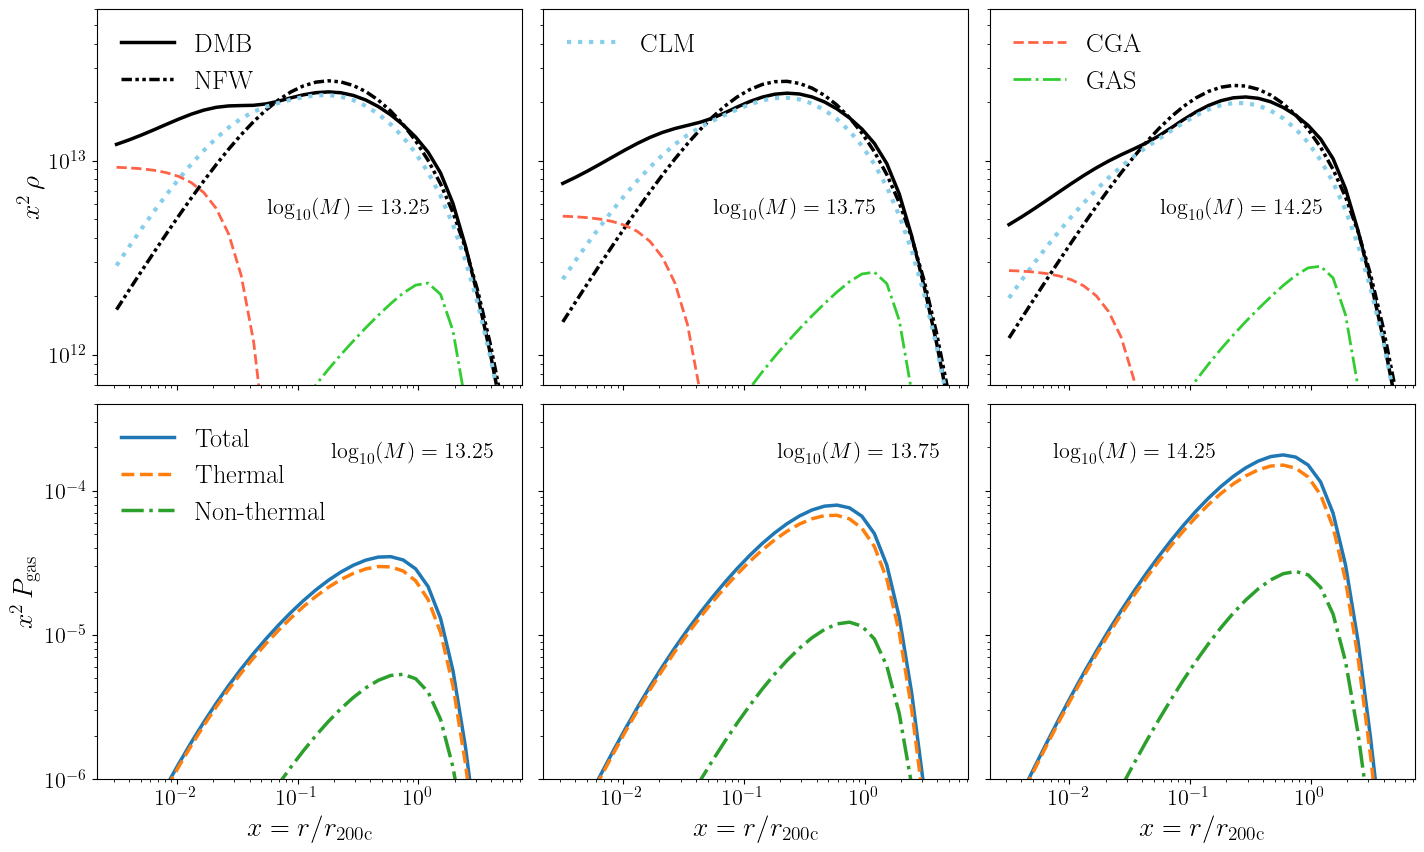

In [35]:
fac = (x_array_data**2)
# fac = 1.
pl.figure()
fig, axes = pl.subplots(2, 3, figsize=(17, 10), sharex=True, sharey='row', gridspec_kw={'hspace': 0.05, 'wspace': 0.05})
for jp in range(2):
    for jM in range(3):
        ax = axes[jp, jM]
        if jp == 0:
            if jM == 0:
                ax.errorbar(x_array_data, fac*rho_dmb_dv_th[0,jM,:], ls='-', lw=2.5, color='k', label='DMB')
                ax.errorbar(x_array_data, fac*rho_nfw_dv_th[0,jM,:], ls=(0, (3, 1, 1, 1, 1, 1)), lw=2.5, color='k', label='NFW')            
                ax.text(0.4, 0.5, r'$\log_{10}(M) = 13.25$', transform=ax.transAxes, fontsize=16, verticalalignment='top')

            else:
                ax.errorbar(x_array_data, fac*rho_dmb_dv_th[0,jM,:], ls='-', lw=2.5, color='k')
                ax.errorbar(x_array_data, fac*rho_nfw_dv_th[0,jM,:], ls=(0, (3, 1, 1, 1, 1, 1)), lw=2.5, color='k')            

            if jM == 1:
                ax.errorbar(x_array_data, fac*rho_clm_dv_th[0,jM,:], ls=':', lw=3, color='skyblue', label='CLM')
                ax.text(0.4, 0.5, r'$\log_{10}(M) = 13.75$', transform=ax.transAxes, fontsize=16, verticalalignment='top')
            else:
                ax.errorbar(x_array_data, fac*rho_clm_dv_th[0,jM,:], ls=':', lw=3, color='skyblue')


            if jM == 2:
                ax.errorbar(x_array_data, fac*rho_cga_dv_th[0,jM,:], ls='--', lw=2, color='tomato', label='CGA')
                ax.errorbar(x_array_data, fac*rho_gas_dv_th[0,jM,:], ls='-.', lw=2, color='limegreen', label='GAS')
                ax.text(0.4, 0.5, r'$\log_{10}(M) = 14.25$', transform=ax.transAxes, fontsize=16, verticalalignment='top')

            else:
                ax.errorbar(x_array_data, fac*rho_cga_dv_th[0,jM,:], ls='--', lw=2, color='tomato')
                ax.errorbar(x_array_data, fac*rho_gas_dv_th[0,jM,:], ls='-.', lw=2, color='limegreen')


            ax.set_ylim(7e11, 6e13)
        if jp == 1:
            if jM == 0:
                ax.errorbar(x_array_data, fac*Ptot_gas_dv_th[0,jM,:], ls='-', lw=2.5, label='Total')
                ax.errorbar(x_array_data, fac*Pth_gas_dv_th[0,jM,:], ls='--', lw=2.5, label='Thermal')
                ax.errorbar(x_array_data, fac*Pnt_gas_dv_th[0,jM,:], ls='-.', lw=2.5, label='Non-thermal')

            else:
                ax.errorbar(x_array_data, fac*Ptot_gas_dv_th[0,jM,:], ls='-', lw=2.5)
                ax.errorbar(x_array_data, fac*Pth_gas_dv_th[0,jM,:], ls='--', lw=2.5)
                ax.errorbar(x_array_data, fac*Pnt_gas_dv_th[0,jM,:], ls='-.', lw=2.5)

            if jM == 0:
                ax.text(0.55, 0.9, r'$\log_{10}(M) = 13.25$', transform=ax.transAxes, fontsize=16, verticalalignment='top')
            if jM == 1:
                ax.text(0.55, 0.9, r'$\log_{10}(M) = 13.75$', transform=ax.transAxes, fontsize=16, verticalalignment='top')
            if jM == 2:
                ax.text(0.15, 0.9, r'$\log_{10}(M) = 14.25$', transform=ax.transAxes, fontsize=16, verticalalignment='top')


            ax.set_ylim(1e-6, 4e-4)
        ax.set_xscale('log')
        ax.set_yscale('log')  
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.tick_params(axis='both', which='minor', labelsize=16)     

        if jp == 0 and jM == 0:
            ax.set_ylabel(r'$x^2 \, \rho$', size=20)


        if jp == 1 and jM == 0:
            ax.set_ylabel(r'$x^2 \, P_{\rm gas}$', size=20)

        if jp == 1:
            ax.set_xlabel(r'$x = r/r_{\rm 200c}$', size=20)

        ax.legend(fontsize=19, frameon=False, loc='upper left')

pl.savefig('/mnt/home/spandey/ceph/GODMAX/notebooks/plots/fig_model_profiles_individual.pdf', bbox_inches='tight')


